In [3]:
!pip install diffusers==0.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 604.0/604.0 kB 37.7 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.15.0
    Uninstalling diffusers-0.15.0:
      Successfully uninstalled diffusers-0.15.0


# Hugging Face Diffusers Library Tutorial: Understanding Models and Schedulers
This notebook showcases the models and APIs available through `diffusers`.

We start below by simply loading a pretrained model and use it to generate an image of a cat. The most important parameter we specify is `num_inference_steps`. Generally, the higher this is the better the image but it does linearly increase compute time.

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


  0%|          | 0/4 [00:00<?, ?it/s]

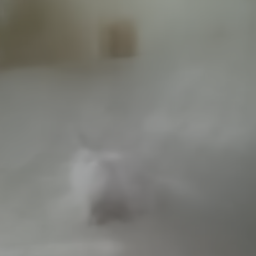

In [10]:
# https://huggingface.co/docs/diffusers/using-diffusers/write_own_pipeline
# High level diffuser pipeline
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256").to("cuda")
image = ddpm(num_inference_steps=4).images[0]
image

  0%|          | 0/300 [00:00<?, ?it/s]

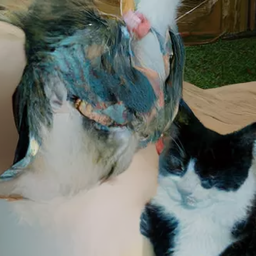

In [11]:
image = ddpm(num_inference_steps=300).images[0]
image

Now we break apart the pipeline to show the main components and how they interact.

In [12]:
# Lower level diffusion libraries
from diffusers import DDPMScheduler, UNet2DModel


scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256").to("cuda")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [13]:
# Set scheduler time steps
scheduler.set_timesteps(25)

In [14]:
scheduler.timesteps

tensor([960, 920, 880, 840, 800, 760, 720, 680, 640, 600, 560, 520, 480, 440,
        400, 360, 320, 280, 240, 200, 160, 120,  80,  40,   0])

In [15]:
# Create random noise with the same shape as the desired output
import torch


sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda")
noise.shape

torch.Size([1, 3, 256, 256])

In [16]:
#  Denoising process
input_t = noise
for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input_t, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input_t).prev_sample
    input_t = previous_noisy_sample

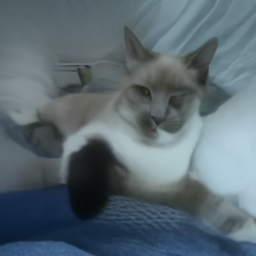

In [17]:
# Convert denoised output to image
from PIL import Image
import numpy as np


image = (input_t / 2 + 0.5).clamp(0, 1)
image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
image = Image.fromarray((image * 255).round().astype(np.uint8))
image

The above example demonstrates denoising diffusion probabilistic models for unconditional image generation. Next up is stable diffusion, a text-to-image latent diffusion model.

In [18]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [22]:
from diffusers import PNDMScheduler


scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [23]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)


UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_features

In [24]:
prompt = ["butter sold by the pound"]
height = 512  # default height of stable diffusion
width = 512  # default width of stable diffusion
num_inference_steps = 25  # number of denoising steps
guidance_scale = 7.5  # scale for classifier-free guidance
generator = torch.manual_seed(0)  # seed generator to create the initial latent noise
batch_size = len(prompt)  # batch size of prompt


In [25]:
# Tokenize the prompt and embed with CLIP

text_input = tokenizer(prompt, padding="max_length", max_length = tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]


In [32]:
text_input["input_ids"].shape

torch.Size([1, 77])

In [33]:
text_embeddings.shape

torch.Size([1, 77, 768])

In [34]:
# Generate unconditional text embeddings
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]


In [35]:
uncond_embeddings.shape

torch.Size([1, 77, 768])

In [36]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


In [37]:
# Generate random noise. Note that we divide by 8 since the vae model has 3 downsample layers
2 ** (len(vae.config.block_out_channels) - 1) == 8

True

In [38]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)


/usr/local/lib/python3.9/dist-packages/diffusers/models/unet_2d_condition.py:452: FutureWarning: Accessing `in_channels` directly via unet.in_channels is deprecated. Please use `unet.config.in_channels` instead
  


In [40]:
# Denoise the image
latents = latents * scheduler.init_noise_sigma  # This is more important for newer schedulers like UniPCMultistep
scheduler.init_noise_sigma

1.0

Basic steps for denoising the image:
1. Set the schedulers timesteps to use during denoising
2. Iterate over the timesteps
3. At each timestep, call the UNet model to predict the noise residual and pass it to the scheduler to compute the previous noisy sample

In [41]:
from tqdm.auto import tqdm


scheduler.set_timesteps(num_inference_steps)
for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predicte the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
    
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample


  0%|          | 0/26 [00:00<?, ?it/s]

In [42]:
# Decode the image
# Scale and decode latents with vae
latents = 1 / 0.18215 * latents  # check if this is correct for the current scheduler
with torch.no_grad():
    decoded = vae.decode(latents).sample


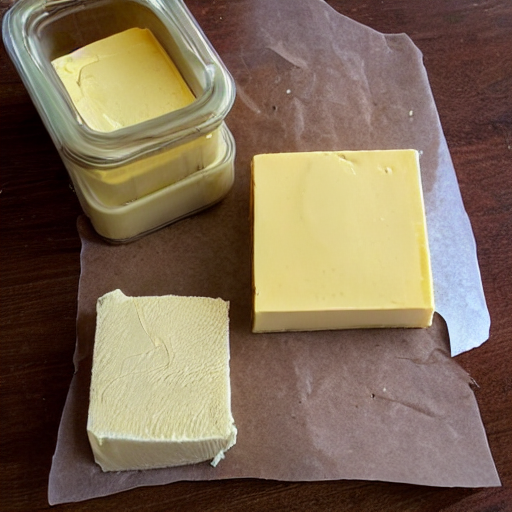

In [44]:
image = (decoded / 2 + 0.5).clamp(0, 1)
image = image.permute(0, 2, 3, 1).detach().cpu().numpy()
images = (image * 255).round().astype(np.uint8)
images = [Image.fromarray(image) for image in images]
images[0]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.
ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


  0%|          | 0/100 [00:00<?, ?it/s]

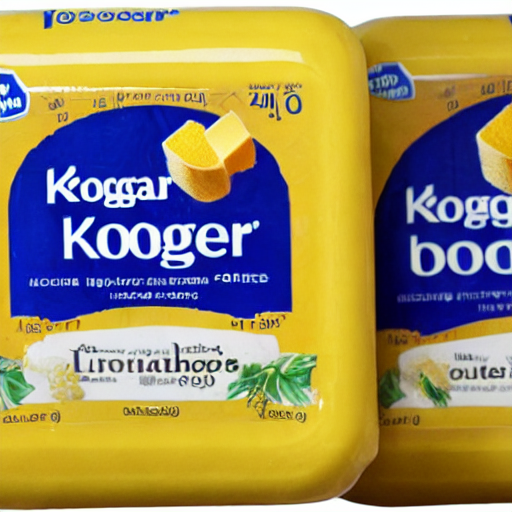

In [7]:
# Stable diffusion function
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
)

text2img = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
text2img = text2img.to("cuda")

def generate_image(prompt, height=512, width=512, num_inference_steps=100):
    return text2img(prompt=prompt, height=height, width=width, num_inference_steps=num_inference_steps)

img = generate_image(["a pound of butter with the kroger logo"])
img[0][0]